In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

,F,G,S
2012-12-28 00:00:00,-0.022250,-0.009135,-0.016712
2012-12-27 00:00:00,-0.000303,0.003862,0.010926
2012-12-26 00:00:00,-0.001669,-0.002358,0.001342
2012-12-24 00:00:00,-0.008411,-0.000995,0.004233
2012-12-21 00:00:00,0.002555,-0.001806,0.003091


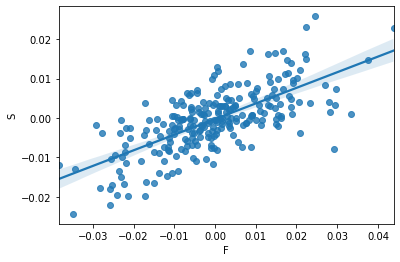

In [14]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df, v["ret"]] , axis = 1)
    
ret_df.columns = data.keys()
display(ret_df.head())
sns.regplot(x="F", y="S", data=ret_df);

# Gaussian

In [15]:
with pm.Model() as model_g:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    slope = pm.Normal('slope', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = pm.Deterministic('mu', intercept + slope * ret_df["F"].values)
    y_pred = pm.Normal('y_pred', mu = mu, sd = sigma, observed= ret_df["S"].values)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:14<00:00, 406.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129a44c50>,
      dtype=object)

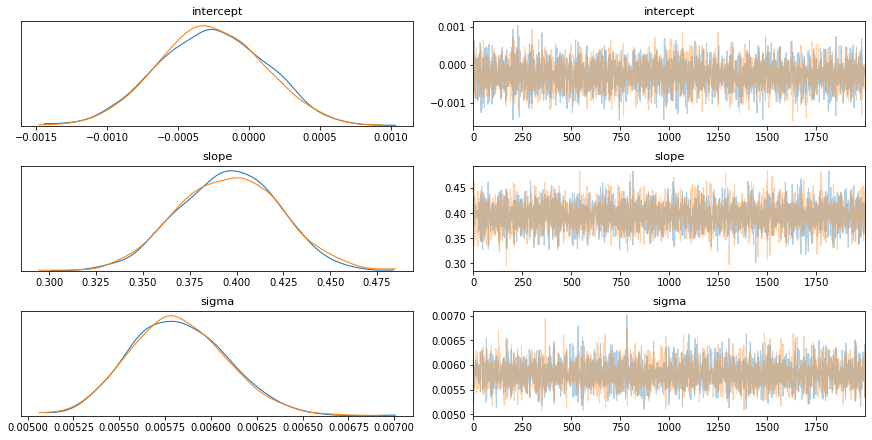

In [18]:
az.plot_trace(trace_g, var_names=['intercept', 'slope', 'sigma'])

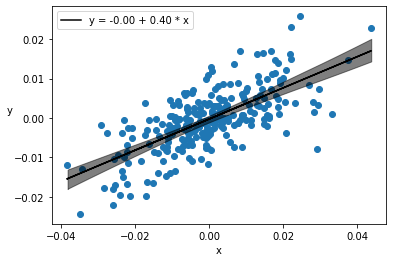

In [48]:
def plot_results(x , y ,trace , plot_type = "" , ppc = []):
    plt.scatter(x, y )

    intercept_m = trace['intercept'].mean()
    slope_m = trace['slope'].mean()

    # Plot of mean
    plt.plot(x, intercept_m + slope_m * x, c='k',label=f'y = {intercept_m:.2f} + {slope_m:.2f} * x')
    
    if plot_type == "":
        # HPD Plot
        sig = az.plot_hpd(x, trace['mu'], credible_interval=0.98, color='k')
    elif plot_type == "all":
        # Plot of simulations
        draws = range(0, len(trace['intercept']), 10)
        plt.plot(x, trace['intercept'][draws] + trace['slope'][draws] * x[:, np.newaxis], c='gray', alpha=0.5)
    elif plot_type == "ppc":      
        az.plot_hpd(x, ppc['y_pred'], credible_interval= .5, color='gray')
        az.plot_hpd(x, ppc['y_pred'], color='gray')
        
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
    
# Plot the HPD
plot_results(ret_df["F"] , ret_df["S"], trace_g )  

100%|██████████| 249/249 [00:00<00:00, 346.37it/s]


r2        0.477523
r2_std    0.021210
dtype: float64

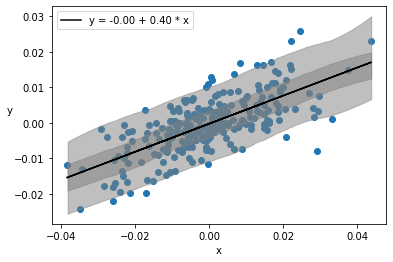

In [55]:
# Plot the HPD of Posterior Predictions
ppc = pm.sample_posterior_predictive(trace_g, samples= len(ret_df["S"]), model=model_g)
plot_results(ret_df["F"] , ret_df["S"], trace_g ,"ppc", ppc)
az.r2_score(ret_df["S"].values, ppc['y_pred'])

# Student

In [66]:
with pm.Model() as model_t:
    intercept = pm.Normal('intercept', mu = ret_df["S"].mean(), sd=1)
    slope = pm.Normal('slope', mu=0, sd=1)
    sigma = pm.HalfNormal('sigma', 5)
#     dof_ = pm.Exponential('dof_', 1/29)
    dof_ = pm.Gamma("dof_",mu = 20 , sd = 15)
    # Shifted Exponential to avoid values close to zero
    dof = pm.Deterministic('dof', dof_ + 1)
    
    mu = pm.Deterministic('mu', intercept + slope * ret_df["F"])
    y_pred = pm.StudentT('y_pred', mu=mu ,sd=sigma, nu=dof, observed=ret_df["S"])

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dof_, sigma, slope, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 434.95draws/s] 
The acceptance probability does not match the target. It is 0.884237551146598, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125ab5bd0>,
      dtype=object)

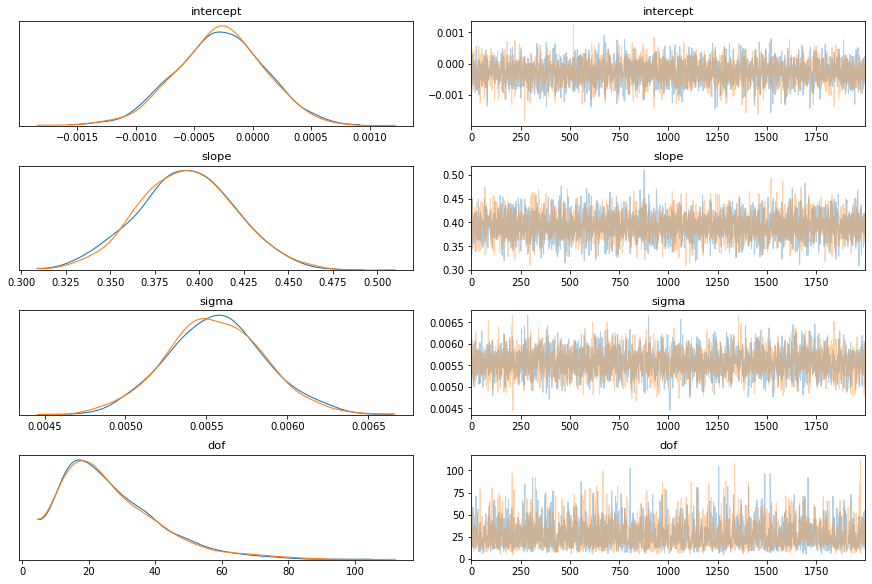

In [67]:
az.plot_trace(trace_t, var_names=['intercept', 'slope', 'sigma', "dof"])

In [68]:
az.summary(trace_t, var_names=['intercept', 'slope', 'sigma', "dof"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-0.000,0.000,-0.001,0.000,0.000,0.000,3658.0,2622.0,3677.0,2734.0,1.0
slope,0.393,0.027,0.341,0.444,0.000,0.000,3797.0,3797.0,3800.0,3324.0,1.0
sigma,0.006,0.000,0.005,0.006,0.000,0.000,2874.0,2874.0,2873.0,2338.0,1.0
dof,27.068,14.928,6.031,53.837,0.263,0.186,3214.0,3214.0,2825.0,2772.0,1.0


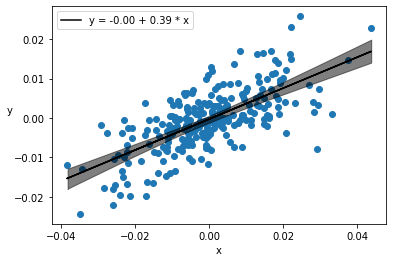

In [70]:
plot_results(ret_df["F"] , ret_df["S"], trace_t)  

100%|██████████| 249/249 [00:07<00:00, 35.47it/s]


r2        0.474281
r2_std    0.024192
dtype: float64

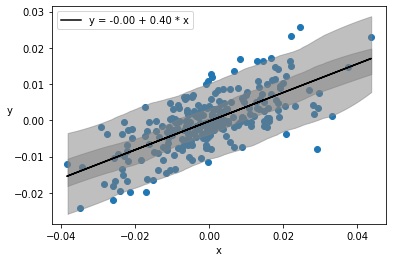

In [71]:
# Plot the HPD of Posterior Predictions
ppc = pm.sample_posterior_predictive(trace_t, samples= len(ret_df["S"]), model=model_t)
plot_results(ret_df["F"] , ret_df["S"], trace_g ,"ppc", ppc)
az.r2_score(ret_df["S"].values, ppc['y_pred'])

arviz.data.io_pymc3 - WARNING - posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


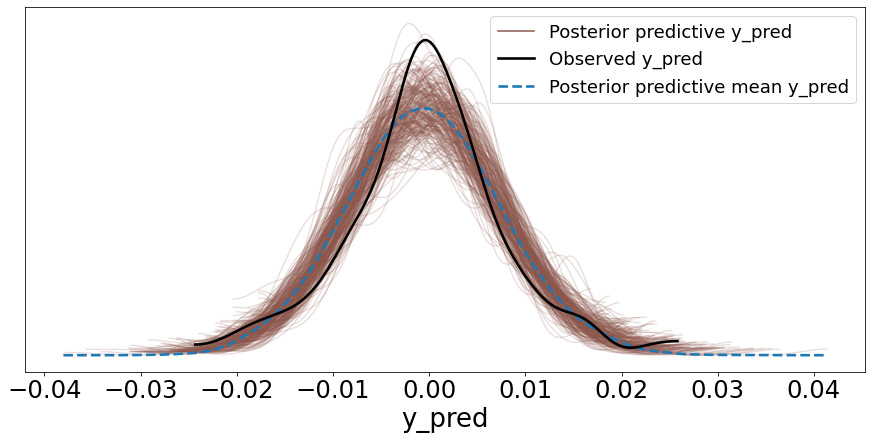

In [72]:
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)